In [1]:
###open cv
##pip install opencv-python

In [3]:
import os
import pandas as pd
import tensorflow as tf
import cv2 ###open cv
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
BASE_DIR = os.path.dirname(os.getcwd())

In [6]:
METADATA_PATH = os.path.join(BASE_DIR, 'data', 'metadata', 'metadata.csv')
IMG_FOLDER_PATH = os.path.join(BASE_DIR, 'data', 'images')

In [7]:
metadata = pd.read_csv(METADATA_PATH)

In [8]:
### 1 alto / 0 bajo
def label_risk(row):
    if row['diagnostic'] in ['SCC', 'BCC', 'MEL']:
        return 1
    else:
        return 0

metadata['risk_label'] = metadata.apply(label_risk, axis=1)
pd.DataFrame(metadata['risk_label'])

,risk_label
0,0
1,1
2,0
3,0
4,1
...,...
2293,0
2294,1
2295,0
2296,1


In [9]:
##trains, test, vals
train_df, temp_df = train_test_split(metadata, test_size=0.3, stratify=metadata['risk_label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['risk_label'])

In [10]:
def preprocess_image(img_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalizar
    return image


In [11]:
def create_dataset(metadata, img_folder):
    img_paths = metadata['img_id'].apply(lambda x: f"{img_folder}/{x}").values
    labels = metadata['risk_label'].values
    images = []
    processed_labels = []
    for img_path, label in zip(img_paths, labels):
        image = preprocess_image(img_path)
        images.append(image)
        processed_labels.append(label)
    return tf.data.Dataset.from_tensor_slices((images, processed_labels))

In [12]:
img_folder = IMG_FOLDER_PATH

In [13]:
train_ds = create_dataset(train_df, img_folder).batch(32).shuffle(100)
val_ds = create_dataset(val_df, img_folder).batch(32)
test_ds = create_dataset(test_df, img_folder).batch(32)

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet') ##investigar pretrained
base_model.trainable = False

In [15]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),  # Usar LeakyReLU
    layers.BatchNormalization(),  # Normalización por lotes
    layers.Dropout(0.5),  # Aumento del Dropout a 0.5
    layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),  # Capa densa adicional
    layers.Dropout(0.5),  # Dropout adicional
    layers.Dense(1, activation='sigmoid') 
])

/Users/kitty.mad/.pyenv/versions/3.10.6/envs/melanoma/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [16]:
model.compile(
    # Usamos Adam con un learning rate bajo (0.0001) para ajustes más finos en el entrenamiento.
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['recall']
)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,785 (9.27 MB)

 Trainable params: 172,545 (674.00 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [18]:
es_callback = EarlyStopping(monitor='val_recall', patience=5, mode='max')

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[es_callback]
)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 403ms/step - loss: 1.1119 - recall: 0.2615 - val_loss: 0.6526 - val_recall: 0.2927
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - loss: 0.9083 - recall: 0.3666 - val_loss: 0.5795 - val_recall: 0.5305
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 385ms/step - loss: 0.8354 - recall: 0.4302 - val_loss: 0.5563 - val_recall: 0.6220
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 444ms/step - loss: 0.7381 - recall: 0.4728 - val_loss: 0.5476 - val_recall: 0.6463
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 398ms/step - loss: 0.7412 - recall: 0.5245 - val_loss: 0.5445 - val_recall: 0.6707
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 405ms/step - loss: 0.6704 - recall: 0.5574 - val_loss: 0.5464 - val_recall: 0.6951
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 424ms/step - loss: 0.6549 - recall: 0.5849 - val_loss: 0.5511 - val_recall: 0.7134
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 25s 413ms/step - loss: 0.6332 - recall: 0.6207 - val_loss: 0.5503 - val_recall:

In [20]:
from tensorflow import keras
model.save('model_3.keras')

In [21]:
evaluation = model.evaluate(test_ds)
print("Evaluación en conjunto de prueba:", evaluation)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 351ms/step - loss: 0.5055 - recall: 0.7463
Evaluación en conjunto de prueba: [0.5084770917892456, 0.7730061411857605]


In [22]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model Recall')
    ax[1].set_ylabel('Recall')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

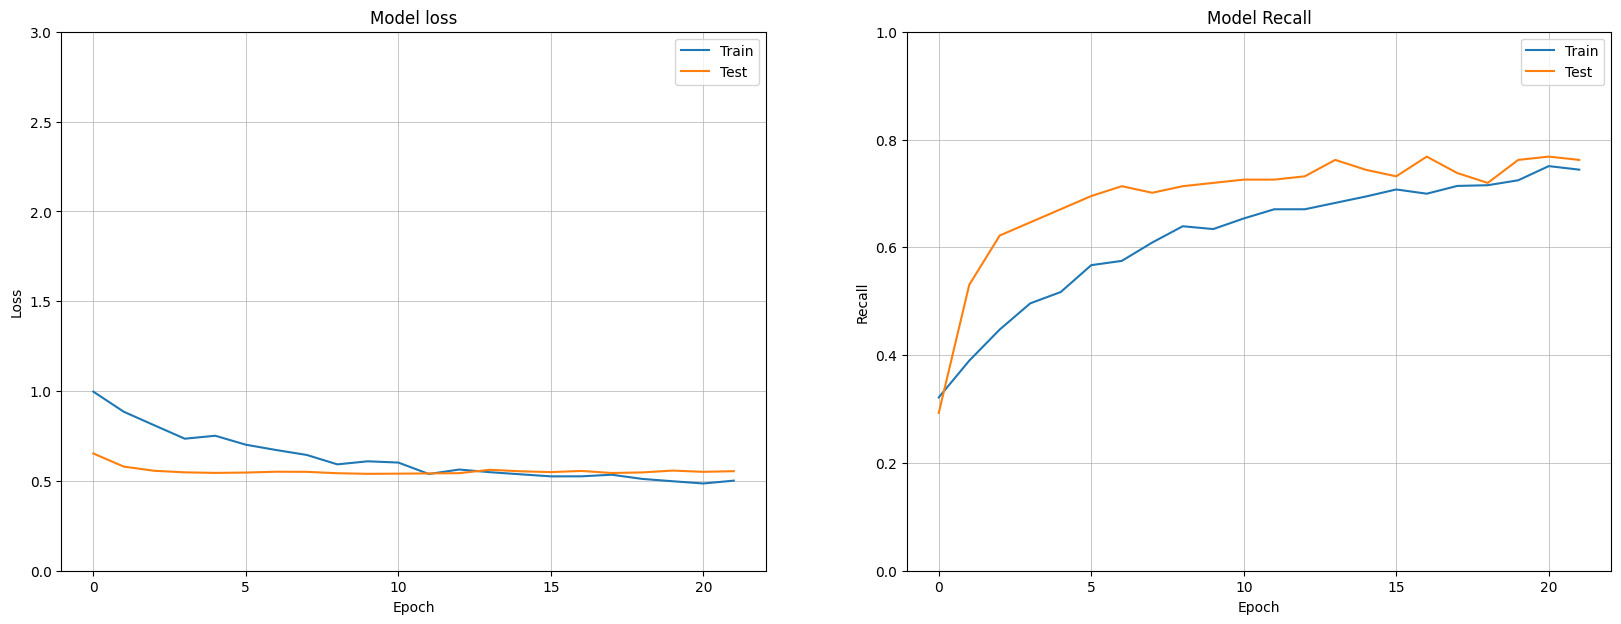

In [23]:
plot_loss_accuracy(history)

In [24]:
def predict_image(img_path):
    image = preprocess_image(img_path)
    image = tf.expand_dims(image, axis=0)  # Agregar dimensión batch
    prediction = model.predict(image)
    risk = "Alto riesgo" if prediction[0][0] > 0.5 else "Bajo riesgo"
    return risk

In [25]:
new_input = os.path.join(BASE_DIR, 'data', 'upload', 'testtest_3.png')
resultado = predict_image(new_input)
print(f"La predicción para la imagen es: {resultado}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
La predicción para la imagen es: Bajo riesgo


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


2024-12-16 16:37:06.104412: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([[139,  43],
       [ 37, 126]])

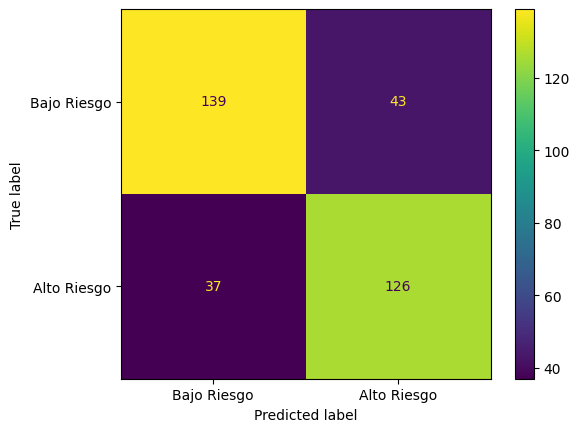

In [26]:
def compute_confusion_matrix(model, dataset):
    all_labels = []
    all_predictions = []
    for images, labels in dataset:
        predictions = model.predict(images)
        predictions = (predictions > 0.5).astype(int).flatten()
        all_labels.extend(labels.numpy())
        all_predictions.extend(predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bajo Riesgo", "Alto Riesgo"])
    disp.plot(cmap='viridis')
    return cm

compute_confusion_matrix(model, test_ds)